### Import Packages

In [1]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import sys
import copy
import torch
import pandas as pd
import dimod
import dwave_networkx as dnx

# Multilayer Friedkin-Johnsen Model

Let a multi-layer graph $G(V,\mathcal {E}=\{E_1,E_2,...,E_L\})$ over the same set of $n$ nodes $V=\{1,2,...,n\}$ with $L$ layer Adjacency matrices $\mathcal{A} = \{A_1, A_2,...,A_L\}$. For each matrix $A_i$ we denote as $W_i$ its row-normalized matrix.
Each node $u\in V$ has an initial inherent opinion $x_u(0)=s_{u}\in[0,1]$.
We consider a generalization of the classic FJ model for multi-layer networks, noted as MFJ model.
More formally, we examine two different opinion dynamics under which node $u$ updates its opinion at time $t$ as follows:
 
Formulation 1: $$x_u(t)=\alpha_us_u+\beta_u x_u(t-1)+\left(1-\alpha_u-\beta_u\right)\sum\limits_{\ell\in[L]}\lambda_{\ell}\mathbf{w}^{\top}_{\ell,u}\mathbf{x}(t-1)$$

Formulation 2: $$x_u(t)=\alpha_us_u+\beta_u x_u(t-1)+\left(1-\alpha_u-
\beta_u\right)\sum\limits_{\ell\in[L]}\lambda_{\ell}(u)\mathbf{w}^{\top}_{\ell,u}\mathbf{x}(t-1)$$
<!-- Let $\mathbf{c_u}=[\alpha_u,\beta_u]^{\top}$ be the unknown vector that corresponds to the biased weights of $u$, i.e. $u$ tends to preserve its initial/inherent and its current opinion. 
In addition, we consider a tranfromation of the column-stochastic normalized adjacency matrix $W$, noted as $W'$, in which for each node $u\in V$ we consider a copy-node $u'\in V'$ of initial opinion $s_{u'}=s_{u}$ and we set $W'[u,u']=1$, $W'[u,u]=1$, $W'[u',u']=1$. The next example illustrates the process:-->
, where $\mathbf{w}_{\ell,u}$ is the $u^{th}$ row of the row-normalized matrix $W_l$.

For a convinient analysis, we introduce the augmented multi-layer graph $G'(V\cup V', \mathcal{E}\cup\{E_{L+1},E_{L+2}\})$ in which for each node $u\in V$ we introduce a copy-node $u'\in V'$ with initial opinion $s_{u'}=s_u$ and we set $A_i[u',u']=W_i[u',u']=1$. Moreover, two extra layers with Adjacency matrices $A_{L+1}$ and $A_{L+2}$ are added to $G$ in order to form $G'$, for which set $A_{L+1}[u',u']=W_{L+1}[u',u']=1$, $A_{L+1}[u,u']=W_{L+1}[u,u']=1$ and $A_{L+2}[u',u']=W_{L+1}[u',u']=1$, $A_{L+2}[u,u]=W_{L+2}[u,u]=1$, respectively. Using $G'$ in the place of $G$ and by setting $\lambda_{L+1}=\alpha_u$ and $\lambda_{L+2}=\beta_u$, we re-write the two formulations as:

Formulation 1: $$x_u(t)=\left(\sum\limits_{\ell\in[L]}\lambda_{\ell}\mathbf{w}^{\top}_{\ell,u}+\sum\limits_{\ell\in\{L+1,L+2\}}\lambda_{\ell}(u)\mathbf{w}^{\top}_{\ell,u}\right)\mathbf{x}(t-1) \,\,\text{ s.t. } \sum\limits_{\ell\in[L]}\lambda_{\ell}+\sum\limits_{\ell\in[L+L+2]}\lambda_{\ell}(u)=1\,\,\,\,\,\,\left|\text{ L+2n unknown variables}\right|$$

Formulation 2: $$x_u(t)=\left(\sum\limits_{\ell\in[L+2]}\lambda_{\ell}(u)\mathbf{w}^{\top}_{\ell,u}\right)\mathbf{x}(t-1)=W_u\mathbf{x}(t-1) \,\,\text{ s.t. } \sum\limits_{\ell\in[L+2]}\lambda_{\ell}(u)=1\,\,\,\,\,\,\left|\text{ (L+2)n unknown variables}\right|$$


### Generate 2-layer stochastic block model

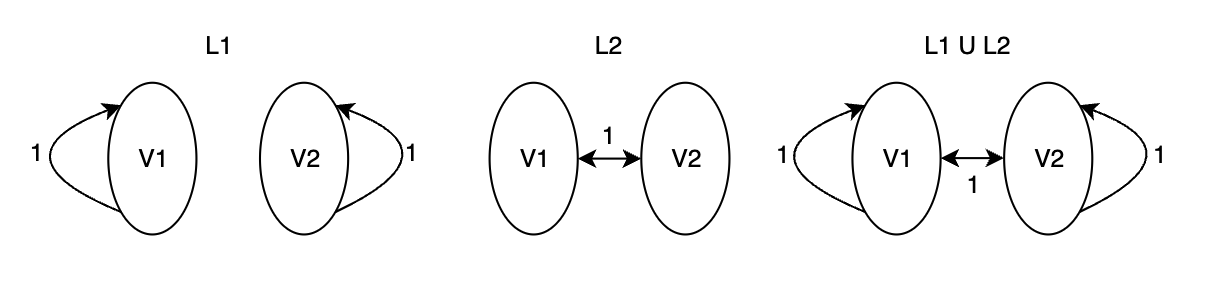

In [2]:
def make_dataset(_name = 'aarhus', n = 61):
    print(f'Making {_name} Graph...')
    df = pd.read_csv(f'./datasets/{_name}/edges.csv')
    Gs = [nx.Graph() for _ in range(3)] #0->Two disconnected components | 1->bipartite | 2->whole graph
    for i in range(3):
        for j in range(n):
            Gs[i].add_node(j)
            Gs[i].add_edge(j, j)
    alledges = 0
    for index, row in df.iterrows():
        u = row['# source']
        v = row[' target']
        Gs[2].add_edge(u, v)
        alledges += 1
    
    sampler = dimod.SimulatedAnnealingSampler()
    cut = dnx.maximum_cut(Gs[2], sampler)
    
    print('n ',n,' and ',' m ', alledges)
    print(f'Nodes of Layer 1 is {len(cut)}')
    print(f'Nodes of Layer 2 is {n - len(cut)}')
    
    edges1 = 0
    edges2 = 0
    edges3 = 0
    for index, row in df.iterrows():
        u = row['# source']
        v = row[' target']
        if (u in cut) and (v in cut):  
            Gs[0].add_edge(u, v)
            edges1 += 1
        elif (u not in cut) and (v not in cut):  
            Gs[0].add_edge(u, v)
            edges2 += 1
        else: 
            Gs[1].add_edge(u, v)
            edges3 += 1
            
    print(f'Edges of Layer 1 is {edges1}')
    print(f'Edges of Layer 2 is {edges2}')
    print(f'Edges of Layer 3 is {edges3}')
    print()
    
    Ws = []
    for i in range(3):
        A = nx.adjacency_matrix(Gs[i]).todense()
        Ws.append(torch.from_numpy((A.T*1/A.sum(axis = 1).T).T).double())
    return Ws

### Set initial opinions (s)

In [3]:
#Initial inherent opinion vector s; 
#Nodes in V1 have opinion o1 and nodes in V2 have opinion o2.
def make_initial_opinions(n1 = 3, n2 = 3, o1 = 1, o2 = 0):
    s1 = np.random.normal(0.9, 0.1, n1)
    s2 = np.random.normal(0.1, 0.1, n2)
    return torch.from_numpy(np.concatenate([s1, s2]))

### Set resistance and history parameters (alphas, betas)

In [4]:
#Resistance parameters alphas; sampled from normal distribution Normal(0.1, 0.1).
#History parameters betas; sampled from normal distribution 0.1 - Normal(0.05, 0.05).
#Return an nx(1 + window_size) matrix; rows correspond to nodes; first column are alphas; last columns are betas
def make_resistance_parameters(n = 100, window_size = 2, seed = 1):
    np.random.seed(seed)
    #sample alphas
    alphabetas = np.random.normal(0.1, 0.3, (n, 1 + window_size))
    #check alpha range be in [0,1]
    for i in range(n):
        for j in range(len(alphabetas[i,:])):
            if alphabetas[i,j] > 1: alphabetas[i,j] = 1
            if alphabetas[i,j] < 0: alphabetas[i,j] = 0
    for i in range(n):
        if np.sum(alphabetas[i,:])<0: 
            for j in range(len(alphabetas[i,:])):
                if alphabetas[i,j] < 0: alphabetas[i,j] = 0
        if np.sum(alphabetas[i,:])>1: alphabetas[i,:] /= np.sum(alphabetas[i,:])
    return torch.from_numpy(alphabetas)

### Set layer parameters (lambdas)

In [5]:
#Layer n*L parameters lambda. Each node u has a layer weight lambda_l(u).
def make_layer_parameters(n1 = 100, n2 = 50, L = 2, l = 0.2, formulation1 = False):
    if formulation1:
        lambda1 = l
        lambda2 = 1 - l
        return torch.from_numpy(np.array([lambda1, lambda2]))
    else:  
        lambdas = np.random.rand(n,L)
        lambdas = (lambdas.T*1/lambdas.sum(axis = 1).T).T
        return  torch.from_numpy(lambdas)

### The (M)FJ model prediction

In [6]:
#Given initial opinions (s), resistance parameters and history parameters(alphas and betas),
#layer weights (lambdas), a (set of) row-normalized adjacency/ies (W) and opinions in [t-window_size] (xts), 
#predict function returns the opinion vector x_{t+1}.
#Parameter formulation1 determines the FJ model to consider.
def predict(s, alphabetas, lambdas, window_size, W, xts, formulation1 = False):
    #number of nodes
    n = len(s)
    #biased inherent and history opinion 
    xt_plus_1 = alphabetas[:,0].reshape(n,1)*s.reshape(n,1)
    if window_size>0:
        xt_plus_1 += torch.diag(alphabetas[:,1:].reshape(n, window_size)@xts.T).reshape(n,1)
    #weighted average of out-neighs opinion
    if formulation1:
        for u in range(n): 
            for l in range(len(lambdas)):
                xt_plus_1[u,0] += float((1-torch.sum(alphabetas[u,:]))*lambdas[l]*(W[l][u,:].reshape(1,n)@xts[:,-1]))
    else:
        for u in range(n):
            for l in range(lambdas.shape[1]):
                xt_plus_1[u,0] += float((1-torch.sum(alphabetas[u,:]))*lambdas[u,l]*(W[l][u,:].reshape(1,n)@xts[:,-1]))
    return xt_plus_1

### Data generation

In [7]:
def make_train_and_test_data(_name_n = ('aarhus', 61, 31, 30), l = 1/4, T = 8, window_size=1, 
                             seed = 1, formulation1 = False, print_data = False, _Ws = None):
    n = _name_n[1]
    data = {}
    #model parameters
    if _Ws is None: data['W'] = make_dataset(_name = _name_n[0], n = _name_n[1])
    else: data['W'] = _Ws
    L = 2
    data['s'] = make_initial_opinions(_name_n[2], n - _name_n[2]).double()
    data['alphabetas'] = make_resistance_parameters(n, window_size, seed).double()
    data['lambdas'] = make_layer_parameters(_name_n[2], n - _name_n[2], L, l, formulation1).double()
    
    #generating data
    data['x'] = []
    colnums = max(1,window_size)
    X = torch.zeros((n, colnums))
    for w in range(colnums):
        X[:,w] = data['s']
    data['x'].append(X)
    
    if print_data:
        print('-----------------------')
        print('X data:')
        print('-----------------------')
        print(X)
        print('-----------------------')
        print('W matrices')
        print('-----------------------')
        print(data['W'][0])
        print(data['W'][1])
        print('Initial Opinions')
        print('-----------------------')
        print(data['s'])
        print('-----------------------')
        print('Alpha and Betas')
        print('-----------------------')
        print(data['alphabetas'])
        print('Lambdas')
        print('-----------------------')
        print(data['lambdas'])

        #check dimensions
        print(data['W'][0].shape)
        print(data['s'].shape)
        print(data['alphabetas'].shape)
        print(data['lambdas'].shape)
        print(data['x'][-1].shape)
    
    
    for _ in range(T): 
        pred = predict(data['s'], data['alphabetas'], data['lambdas'], window_size, data['W'][0:2], data['x'][-1].double(), formulation1)
        data['x'].append(torch.zeros((n, colnums)))
        data['x'][-1][:,:-1] = data['x'][-2][:,1:]
        data['x'][-1][:,-1] = pred.reshape(-1)

    return data

### Make the dataset

##### Number of nodes and edges may differ as the maximum-cut algorithm does not provide an optimal solution.

In [8]:
_name_n = ('aarhus', 61, 31, 30)
#_name_n = ('jazz', 198, 87)
#_name_n = ('facebook', 362, 171)
#_name_n = ('school', 702, 404)
dataset_name = _name_n[0]
generated_formulation1 = True  #set to True for MFJ_1 and set False for MFJ_2 
iters = 10   #set the number of iters for more instances, i.e. 10.
T = 10  #number of timestamps
window_size = True #set to False for memory-free MFJ
n = _name_n[1]
dataset = []
_Ws = make_dataset(_name = _name_n[0], n = _name_n[1])
for i in range(iters): 
    dataset.append(make_train_and_test_data(_name_n = _name_n, seed = 100*i+int(1*10), T=T, window_size = window_size, 
                                            formulation1 = generated_formulation1, _Ws = _Ws))

Making aarhus Graph...
n  61  and   m  620
Nodes of Layer 1 is 29
Nodes of Layer 2 is 32
Edges of Layer 1 is 129
Edges of Layer 2 is 110
Edges of Layer 3 is 381



### Projected Gradient Descent  (PGD)

In [9]:
import numpy as np
from numpy import linalg as LA
import torch
import torch.nn as nn
import cvxpy as cp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TensorSolver:
    #Init Function
    def __init__(self, b, window_size, Ws, x, y, loss_function = torch.nn.MSELoss(reduction = 'sum'), formulation1 = False):
        #number of nodes
        self.n = len(Ws[0])
        #number of layers
        self.L =  len(Ws)
        #number of timestamps
        self.T = len(x)
        #window_size
        self.window_size = window_size
        #formulation type
        self.formulation1 = formulation1
        #Unknown variables: 
        # first column are biased-lambdas 
        # second window_size are memory-lambdas
        if self.formulation1:
            self.alphabetas = torch.from_numpy(np.ones((self.n, self.window_size+1))/(self.window_size+self.L+1)).to(device)
        else:
            self.alphabetas = torch.from_numpy(np.ones((self.n, self.window_size+1))/(self.window_size+self.L+1)).to(device)
        self.alphabetas.requires_grad_(True)
        # lambdas are layer-lambdas
        if self.formulation1:
            self.lambdas = torch.from_numpy(np.ones((self.L, 1))/self.L).to(device)
        else: 
            self.lambdas = torch.from_numpy(np.ones((self.n, self.L))/(self.window_size+self.L+1)).to(device)
        self.lambdas.requires_grad_(True)
        #Loss function
        self.criterion = loss_function
        #biases
        self.b = b
        #stochastic matrices
        self.Ws = Ws
        #input
        self.x = x
        #output
        self.y = y
        
    #Predict Function 
    def pred(self, t = 0):
        prediction = self.alphabetas[:,0].reshape(-1,1)*self.b
        if window_size>0:
            prediction += torch.diag(self.alphabetas[:,1:]@self.x[t].T).reshape(-1,1)
        if self.formulation1:
            for l in range(self.L): 
                prediction += self.lambdas[l,0]*(self.Ws[l]*((1-torch.sum(self.alphabetas, axis=1).reshape(-1,1))@torch.ones((1,self.n)).double()))@(self.x[t][:,-1].reshape(-1,1))
            return prediction    
        else:
            for l in range(self.lambdas.shape[1]):
                prediction += (self.lambdas[:,l].reshape(-1,1)*self.Ws[l])@(self.x[t][:,-1].reshape(-1,1))
            return prediction    


    #Loss Function
    def loss(self, T=None):
        if T is not None: toprint = True
        if T is None: T = self.T
        squared_all = 0
        for t in range(T):
            squared_all = squared_all + (1/self.T)*self.criterion(self.pred(t), self.y[t])
        return squared_all
    
    
    #L1
    def lossL1(self, T=None):
        if T is not None: toprint = True
        if T is None: T = self.T
        squared_all = 0
        for t in range(T):
            squared_all = squared_all + (1/self.T)*torch.nn.L1Loss()(self.pred(t), self.y[t])
        return squared_all
    
    
    #Gradient Descent
    def gradient(self, lr = 1):
        if self.alphabetas.requires_grad and self.lambdas.requires_grad:
            self.loss().backward()
            self.alphabetas.data  -= lr*self.alphabetas.grad.data
            self.lambdas.data  -= lr*self.lambdas.grad.data
            self.projection_new()
        

    #Projection Onto A Simplex
    #Yunmei Chen and Xiaojing Ye
    def projsplx(self, X):
        X2 = torch.sort(X, 1)[0]
        _n = X2.shape[0]
        _l = X2.shape[1]

        i = _l-2
        current_mult = torch.ones((_n, 1))
        t_pred = torch.zeros((_n, 1))

        while i>=0:
            y_i = X2[:,i].reshape(-1,1)
            t_i = ((torch.sum(X2[:,i+1:], axis = 1)-1)/(_l - (i+1))).reshape(-1,1)
            t_pred += t_i*(t_i>=y_i)*current_mult
            current_mult = current_mult*(t_i<y_i)
            i -= 1

        t_i = ((torch.sum(X, axis = 1)-1)/_l).reshape(-1,1)
        t_pred += t_i*current_mult
        return (X - t_pred)*(X>t_pred)
            
            
    #Projection to feasible solution
    def projection_new(self):

        if self.formulation1:
            self.lambdas.grad.zero_()
            Lambdas = self.lambdas.data
            Lnew = cp.Variable(Lambdas.shape)
            prob = cp.Problem(cp.Minimize(cp.sum_squares(Lambdas - Lnew)),
                              [Lnew >= 0,
                               Lnew <= 1,
                               cp.sum(Lnew[-self.L:])==1])
            prob.solve()
            self.lambdas = torch.tensor(Lnew.value)
            self.lambdas.requires_grad_()  
        else:
            self.lambdas.grad.zero_()
            self.alphabetas.grad.zero_()
            Lambdas = self.lambdas.data
            Alphabetas = self.alphabetas.data
            
            #Projection Onto A Simplex
            #Yunmei Chen and Xiaojing Ye
            Lnew = self.projsplx(torch.cat((Lambdas,Alphabetas),dim=1))

            self.lambdas = Lnew[:,:Lambdas.shape[1]]
            self.lambdas.requires_grad_()    
            
            self.alphabetas = Lnew[:,-Alphabetas.shape[1]:]  
            self.alphabetas.requires_grad_()  
            
        
        if self.formulation1:
            self.alphabetas.grad.zero_()
            Alphabetas = self.alphabetas.data
            Alphabetasnew = cp.Variable(Alphabetas.shape)
            prob = cp.Problem(cp.Minimize(cp.sum_squares(Alphabetas - Alphabetasnew)),
                              [Alphabetasnew >= 0,
                               Alphabetasnew <= 1,
                               cp.sum(Alphabetasnew, axis=1)<=np.ones(len(Alphabetas))])
            prob.solve()
            self.alphabetas = torch.tensor(Alphabetasnew.value)
            self.alphabetas.requires_grad_()  
            
            self.optimizer = torch.optim.SGD([self.alphabetas, self.lambdas], lr=0.01)
        
    
    #Training Phase
    def training(self, num_epochs = 1000, lrdiv = 5, printall = True, printL1 = True, decay = 0.999): 
        if printall: 
            if printL1: print('Initial: ',self.lossL1().item())
            else: print('Initial: ',self.loss().item())
        training_loss = []
        lr = lrdiv
        for epoch in range(num_epochs):
            lr *= decay 
            self.gradient(lr=lr) 
            lossval = 0
            if printL1: lossval = self.lossL1().item()
            else: lossval = self.loss().item()
            training_loss.append(lossval)
            if printall:
                if epoch % 1 == 0:
                    print(f"Epoch: {epoch}, L1 loss {lossval:.8}")
                    print(f"Epoch: {epoch}, L2 loss {self.loss().item():.8}")
                    print()
        return training_loss

    
    #Testing Phase
    def test(self, Ws, x, y):
        #number of nodes
        self.n = len(Ws[0])
        #number of layers
        self.L =  len(Ws)
        #number of timestamps
        self.T = len(Ws)
        #Loss function
        #self.criterion = torch.nn.MSELoss()
        self.criterion = torch.nn.L1Loss()
        #input
        self.x = x
        #output
        self.y = y
        return self.loss(T=len(y)) 


In [10]:
#Run the experiments
def run_the_experiments(data_, T_train, T_test, window_size, algname = 'multi'):
    results = {}
    results['train_loss'] = []
    results['train_epoch'] = []
    results['test_loss'] = []
    results['alphabetas'] = []
    results['lambdas'] = []
    for i in range(len(data_)):
        data = copy.deepcopy(data_)
        Ws_ = copy.deepcopy(data[i]['W'])
        n = len(Ws_[0])
        print(f'Algorithm {algname}')
        formulation1 = True
        if algname == 'multi1': Ws_ = [data[i]['W'][0], data[i]['W'][1]]
        elif algname == 'multi2': 
            Ws_ = [data[i]['W'][0], data[i]['W'][1]]
            formulation1 = False
        elif algname == 'l1': Ws_ = [data[i]['W'][0], data[i]['W'][0]]
        elif algname == 'l2': Ws_ = [data[i]['W'][1], data[i]['W'][1]]
        elif algname == 'lboth': Ws_ = [data[i]['W'][2], data[i]['W'][2]]
        else: return
        colnum = max(1, window_size)
        x_train = [data[i]['x'][j].reshape(n, colnum).double() for j in range(0,T_train)]
        y_train = [data[i]['x'][j][:,-1].reshape(n, 1).double() for j in range(1,T_train+1)]
        x_test = [data[i]['x'][j].reshape(n, colnum).double() for j in range(T_train, T_train+T_test)]
        y_test = [data[i]['x'][j][:,-1].reshape(n, 1).double() for j in range(T_train+1, T_train+T_test+1)]
        
        solver  = TensorSolver(data[i]['s'].reshape(n,1), window_size, Ws_, x = x_train, y = y_train, 
                               formulation1 = formulation1)
        
        lr = 0.1
        if algname == 'multi2': lr = 0.9
        #if algname == 'l1': lr = 1
        train_loss = solver.training(num_epochs = 5000, lrdiv = lr, printall = False, printL1 = True, decay = 1) #change False to True for printing loss
        #print(train_loss)
        test_loss = []
        #s, alphabetas, lambdas, window_size, W, xts
        for t in range(T_test):
            if algname != 'multi2': 
                test_loss.append(torch.nn.L1Loss()(predict(data[i]['s'].reshape(n,1), 
                                                           solver.alphabetas.detach(),
                                                           solver.lambdas.detach().reshape(-1),
                                                           window_size,
                                                           Ws_, 
                                                           x_test[t], formulation1).reshape(n,1), y_test[t].reshape(n,1)).numpy())
            else:
                test_loss.append(torch.nn.L1Loss()(predict(data[i]['s'].reshape(n,1), 
                                                       solver.alphabetas.detach(),
                                                       (solver.lambdas.detach()/((1-torch.sum(solver.alphabetas.detach(), axis = 1)) + ((1-torch.sum(solver.alphabetas.detach(), axis = 1))<0.000000001).type(torch.float64)).reshape(-1,1)) * ((1-torch.sum(solver.alphabetas.detach(), axis = 1))>0.00000000001).type(torch.float64).reshape(-1,1),
                                                       window_size,
                                                       Ws_, 
                                                       x_test[t],formulation1).reshape(n,1), y_test[t].reshape(n,1)).numpy())
                
        print('Test Loss: ', test_loss)
        results['train_epoch'].append(train_loss)
        results['test_loss'].append(np.mean(test_loss))
        results['alphabetas'].append(solver.alphabetas.detach().numpy())
        if formulation1: results['lambdas'].append(solver.lambdas.detach().numpy())
        else: results['lambdas'].append(((solver.lambdas.detach()/((1-torch.sum(solver.alphabetas.detach(), axis = 1)) + ((1-torch.sum(solver.alphabetas.detach(), axis = 1))<0.000000001).type(torch.float64)).reshape(-1,1)) * ((1-torch.sum(solver.alphabetas.detach(), axis = 1))>0.00000000001).type(torch.float64).reshape(-1,1)).numpy())
        
        train_loss = []
        for t in range(T_train):
            if algname != 'multi2': 
                prediction = predict(data[i]['s'].reshape(n,1), 
                                     solver.alphabetas.detach(),
                                     solver.lambdas.detach().reshape(-1),
                                     window_size,
                                     Ws_, 
                                     x_train[t],formulation1).reshape(n,1)
            else:
                prediction = predict(data[i]['s'].reshape(n,1), 
                                 solver.alphabetas.detach(),
                                 (solver.lambdas.detach()/((1-torch.sum(solver.alphabetas.detach(), axis = 1)) + ((1-torch.sum(solver.alphabetas.detach(), axis = 1))<0.000000001).type(torch.float64)).reshape(-1,1)) * ((1-torch.sum(solver.alphabetas.detach(), axis = 1))>0.00000000001).type(torch.float64).reshape(-1,1),
                                 window_size,
                                 Ws_, 
                                 x_train[t], formulation1).reshape(n,1)
            train_loss.append(torch.nn.L1Loss()(prediction, y_train[t].reshape(n,1)).numpy())
        print(f'Train Loss: {train_loss}')
        results['train_loss'].append(np.mean(train_loss))
    return results
 

In [11]:

T_train = 5
T_test = 5
alg_results = {}
for algname in ['multi1', 'multi2', 'l1', 'l2', 'lboth']: 
    alg_results[algname] = run_the_experiments(dataset, T_train, T_test, window_size, algname)  

Algorithm multi1
Test Loss:  [array(0.00070327), array(0.00080906), array(0.00088473), array(0.00093896), array(0.00097756)]
Train Loss: [array(0.00084956), array(0.00068964), array(0.00033159), array(0.0003451), array(0.00055326)]
Algorithm multi1
Test Loss:  [array(0.00089593), array(0.00108707), array(0.00123172), array(0.00134151), array(0.00142511)]
Train Loss: [array(0.00095505), array(0.00086897), array(0.00048832), array(0.00043862), array(0.00067203)]
Algorithm multi1
Test Loss:  [array(0.0012009), array(0.00133491), array(0.00144433), array(0.00153072), array(0.00160049)]
Train Loss: [array(0.00167082), array(0.00116658), array(0.00064121), array(0.00083001), array(0.00103145)]
Algorithm multi1
Test Loss:  [array(0.00078988), array(0.0009148), array(0.0010092), array(0.00108124), array(0.00113625)]
Train Loss: [array(0.00097093), array(0.00060601), array(0.00038341), array(0.00039911), array(0.00062331)]
Algorithm multi1
Test Loss:  [array(0.00051865), array(0.00056814), arra

Test Loss:  [array(0.00456492), array(0.00488999), array(0.0051217), array(0.00529446), array(0.00542598)]
Train Loss: [array(0.00874449), array(0.00546816), array(0.00330653), array(0.00347098), array(0.00409567)]
Algorithm l2
Test Loss:  [array(0.00434968), array(0.00471793), array(0.00500719), array(0.00523395), array(0.00541786)]
Train Loss: [array(0.00976808), array(0.00708064), array(0.00404009), array(0.00355388), array(0.00390037)]
Algorithm l2
Test Loss:  [array(0.00453224), array(0.00489399), array(0.00515357), array(0.00534122), array(0.00548049)]
Train Loss: [array(0.0077488), array(0.00638799), array(0.0033199), array(0.003376), array(0.00403822)]
Algorithm l2
Test Loss:  [array(0.00295974), array(0.00315497), array(0.0033001), array(0.00340098), array(0.00347199)]
Train Loss: [array(0.00874249), array(0.00389916), array(0.00219889), array(0.00232842), array(0.0026969)]
Algorithm lboth
Test Loss:  [array(0.00273324), array(0.00291158), array(0.00303503), array(0.00312022),

### Average results

In [12]:
i = 0
for algname in alg_results:
    if i>4: break
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_epoch_mean'] = np.mean(alg_results[algname]['train_epoch'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphabetas_mean'] = np.mean(alg_results[algname]['alphabetas'], axis = 0)
    alg_results[algname]['lambdas_mean'] = np.mean(alg_results[algname]['lambdas'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['train_epoch_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphabetas_std'] = np.std(alg_results[algname]['alphabetas'], axis = 0)
    alg_results[algname]['lambdas_std'] = np.std(alg_results[algname]['lambdas'], axis = 0)
    i+=1

### Plot average train loss vs epochs

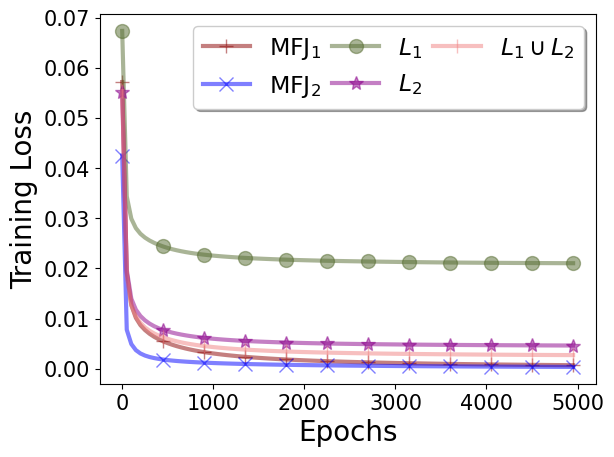

In [13]:
def plot_train_loss(alg_results, window_size = False, formulation1 = False, dataset_name = 'aarhus'):
    fig, axes = plt.subplots(1)
    names_plot = [r'MFJ$_1$', r'MFJ$_2$', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$', 'ARIMA', 'Naive']
    colors = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta', 'lightcoral', 'hotpink', 'lightgreen']
    hatches = ['+', 'x','o', '*','|', '-', '\\']
    ax1 = axes
    j = 0
    start = 0
    for algname in alg_results:
        if j>4: break
        ax1.plot(range(start+1, len(alg_results[algname]['train_epoch_mean']) + 1, 50), 
                 alg_results[algname]['train_epoch_mean'][range(start+1, len(alg_results[algname]['train_epoch_mean']) + 1, 50)], 
                 color = colors[j], label = names_plot[j],linewidth=3.0,
                 marker = hatches[j], markevery=9, markersize=10, alpha = 0.5)
        j += 1
    plt.legend(fontsize=17, loc='upper right',#, bbox_to_anchor=(0.52, 1.0),
          ncol=3, fancybox=True, shadow=True, columnspacing=0.47)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Training Loss', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/train_loss_vs_epoch_real_{int(window_size)}_{int(formulation1)}_{dataset_name}.pdf', 
                format = 'pdf', bbox_inches='tight', dpi=1200)
    plt.show()
    
plot_train_loss(alg_results, window_size, generated_formulation1, dataset_name)

### Plot average test loss 

In [14]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
def plot_loss(alg_results, name_ = 'test', window_size = True, formulation1 = False, dataset_name = 'aarhus'):
    fig, axes = plt.subplots()
    names_plot = [r'MFJ$\mathbf{_1}$', r'MFJ$\mathbf{_2}$', r'L$\mathbf{_1}$', r'L$\mathbf{_2}$', r'L$\mathbf{_1\cup}$L$\mathbf{_2}$', 'ARIMA', 'Naive']
    m  = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta', 'lightcoral', 'hotpink', 'lightgreen']
    hatches = ['-\\', 'x','o', '+','+o', '-', '\\']
    i = 0
    max_ = -1
    for algname in alg_results:
        x = np.arange(1)  # the label locations
        width = 0.15      # the width of the bars
        offset = width * i
        max_ = max(alg_results[algname][f'{name_}_loss_mean'], max_)
        print(f'{algname} -> {alg_results[algname][f"{name_}_loss_mean"]}')
        axes.bar(x + offset, alg_results[algname][f'{name_}_loss_mean'], 3*width/4,
                label=names_plot[i], color = m[i],
                hatch=hatches[i], alpha = 0.5)
        axes.yaxis.offsetText.set_fontsize(24)
        axes.errorbar(x + offset, alg_results[algname][f'{name_}_loss_mean'],
                      alg_results[algname][f'{name_}_loss_std'],
                            fmt="o", color='black', alpha = 0.5)
        i += 1
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    

    plt.ylim(top=max_+0.9*max_)
    plt.ylim(bottom=0)
    plt.legend(fontsize=17.5, loc='upper center', bbox_to_anchor=(0.497, 1.0),
          ncol=3, fancybox=True, shadow=True, columnspacing=0.47)
    y_label = 'Testing Loss'     
    if name_ == 'train': y_label = 'Training Loss' 
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,-1))
    plt.ylabel(y_label, fontsize=25)
    plt.yticks(fontsize=25)
    plt.savefig(f'./Figures/{name_}_loss_real_{int(window_size)}_{int(formulation1)}_{dataset_name}.pdf', 
                bbox_inches='tight', format='pdf', dpi=2000)
    plt.show()
    
#plot_loss(alg_results, 'train', window_size, generated_formulation1, dataset_name)
#plot_loss(alg_results, 'test', window_size, generated_formulation1, dataset_name)

multi1 -> 0.0007162306584192265
multi2 -> 0.0003779506125869285
l1 -> 0.021045389084627057
l2 -> 0.0046447354295699236
lboth -> 0.002732953305482038


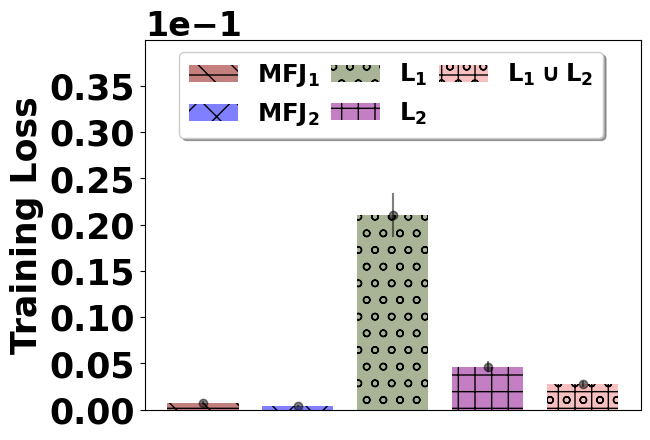

multi1 -> 0.0010665868630535882
multi2 -> 0.0006548909035508139
l1 -> 0.013286417014277501
l2 -> 0.00448361231084749
lboth -> 0.0034180397791082574


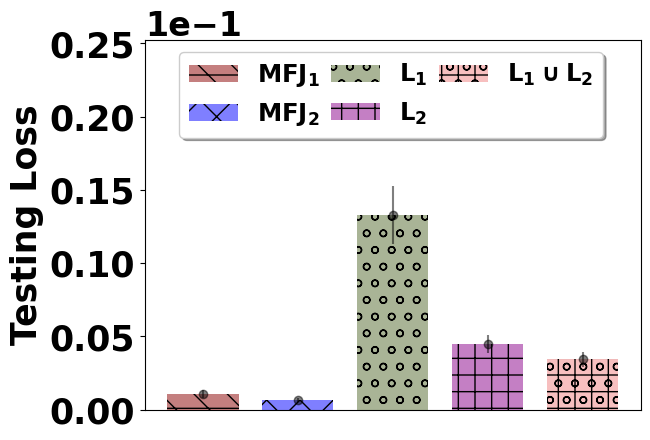

In [15]:
plot_loss(alg_results, 'train', window_size, generated_formulation1, dataset_name)
plot_loss(alg_results, 'test', window_size, generated_formulation1, dataset_name)

### Plot distribution of average predicted alphas, betas and lambdas parameters  

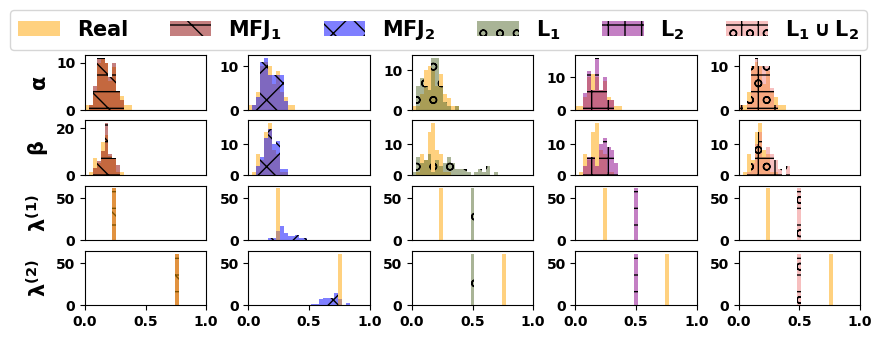

In [16]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
def plot_alpha_beta_distribution(alg_results, window_size, dataset, formulation1 = False, dataset_name = 'aarhus'):
    bins=[i/31 for i in range(32)]
    names_plot = [r'MFJ$\mathbf{_1}$', r'MFJ$\mathbf{_2}$', r'L$\mathbf{_1}$', r'L$\mathbf{_2}$', r'L$\mathbf{_1\cup}$L$\mathbf{_2}$', 'ARIMA', 'Naive']
    colors = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta', 'lightcoral', 'hotpink', 'lightgreen']
    hatches = ['-\\', 'x','o', '+','+o', '-', '\\']
    #if formulation1: names_plot[0] = r'MFJ$_1$'
    _cols = len(alg_results)
    if _cols>5: _cols = 5
    fig, ax = plt.subplots(3+(int(window_size)),_cols, squeeze = False)
    plt.subplots_adjust(top = 1, bottom=0.5, hspace=0.2, wspace=0.35)
    for k in range(window_size, -1, -1):
        real_alphabetas_mean = np.zeros(len(dataset[0]['alphabetas']))
        for l in range(len(dataset)):
            real_alphabetas_mean += ((dataset[l]['alphabetas'][:,k].numpy())/len(dataset)).reshape(-1)
        
        i = 0
            
        for algname in alg_results:
            if i>4: break
            ax[k,i].set_xticks([])
            ax[k,i].figure.set_size_inches(10, 5)
            
            #ax[k,i].hist(np.array(alg_results[algname]['alphabetas_mean'][:,k]), bins=10, 
            #         facecolor = 'none' ,label = names_plot[i], edgecolor=colors[i])
            cname = 'Real'
            if(k>0 or i>0): cname = None
            ax[k,i].hist(np.array(real_alphabetas_mean), bins=bins, 
                     color = 'orange', alpha = 0.5, label = cname)
            #ax[k,i].hist(np.array(real_alphabetas_mean), bins=10, 
            #         facecolor="none", label = 'Real', edgecolor='orange')
            
            cname = names_plot[i]
            if k>0: cname = None
            ax[k,i].hist(np.array(alg_results[algname]['alphabetas_mean'][:,k]), bins=bins, 
                     color = colors[i], alpha = 0.5,label = cname, hatch=hatches[i])
            
            ax[k,i].set_xlim(0, 1)
            #ax[k,i].set_ylim(0, 15)
            
            ax[k,i].tick_params(axis='both', which='major', labelsize=10)
            ax[k,i].tick_params(axis='both', which='minor', labelsize=8)
            if i==0:
                if k == 0:
                     ax[k,i].set_ylabel(r'$\mathbf{\alpha}$', fontsize=15)
                else: 
                    t = k-window_size+1
                    #plt.xlabel(r'$\beta$'f'(t-{t})', fontsize=15)
                    ax[k,i].set_ylabel(r'$\mathbf{\beta}$', fontsize=15)
                    parameter_ = r'$\beta$'
            
            i += 1
    _n = len(real_alphabetas_mean)        
    for k in range(2):
        if formulation1 == False:
            real_lambdas_mean = np.zeros(len(dataset[0]['lambdas'][:,k].numpy()))
            for l in range(len(dataset)):
                real_lambdas_mean += ((dataset[l]['lambdas'][:,k].numpy())/len(dataset)).reshape(-1)
        else:
            real_lambdas_mean = 0
            for l in range(len(dataset)):
                    real_lambdas_mean += (dataset[l]['lambdas'].numpy()[k])/len(dataset)
            real_lambdas_mean = np.array([real_lambdas_mean for _ in range(_n)])
        
        i = 0
        
        for algname in alg_results:
            if i>4: break
            if k<1: ax[k+1+(int(window_size)),i].set_xticks([])
            ax[k+1+(int(window_size)),i].figure.set_size_inches(10, 5)
            cname = None
            if (algname == 'multi2'):
                ax[k+1+(int(window_size)),i].hist(np.array(alg_results[algname]['lambdas_mean'][:,k]), bins=bins, 
                         color = colors[i], alpha = 0.5,label = cname, hatch=hatches[i])
            else:
                ax[k+1+(int(window_size)),i].hist(np.array([alg_results[algname]['lambdas_mean'][k] for _ in range(len(real_lambdas_mean))]), bins=bins, 
                         color = colors[i], alpha = 0.5,label = cname, hatch=hatches[i])
            cname = None
            if formulation1 == False:
                print(real_lambdas_mean)
                ax[k+1+(int(window_size)),i].hist(np.array(real_lambdas_mean), bins=bins, 
                         color = 'orange', alpha = 0.5, label = cname)
            else:
                ax[k+1+(int(window_size)),i].hist(np.array(real_lambdas_mean), bins=bins, 
                         color = 'orange', alpha = 0.5, label = cname)
            ax[k+1+(int(window_size)),i].set_xlim(0, 1)
            #ax[k+1+(int(window_size)),i].set_ylim(0, 15)
            
            ax[k+1+(int(window_size)),i].tick_params(axis='both', which='major', labelsize=10)
            ax[k+1+(int(window_size)),i].tick_params(axis='both', which='minor', labelsize=8)
            if i==0:
                if k == 0: ax[k+1+(int(window_size)),i].set_ylabel(r'$\mathbf{\lambda^{(1)}}$', fontsize=15)
                else: ax[k+1+(int(window_size)),i].set_ylabel(r'$\mathbf{\lambda^{(2)}}$', fontsize=15)            
            i += 1
    #fig.set_size_inches(2, 5)
    #fig.legend(loc=(0.1, 0.9), ncol=6, fontsize=14, bbox_to_anchor=(-0.25, 1.01), borderaxespad=0.1)
    
    fig.set_size_inches(10, 5)
    fig.legend(loc=(0.1, 0.9), ncol=6, fontsize=15, bbox_to_anchor=(0.05, 1.01), borderaxespad=0.1)
    
    #plt.tight_layout()
    #ax.legend(fontsize=15)
    plt.savefig(f'./Figures/distribution_real_{int(window_size)}_{int(generated_formulation1)}_{dataset_name}.pdf', bbox_inches='tight', 
                format='pdf',dpi=2000)
    plt.show()

plot_alpha_beta_distribution(alg_results, window_size, dataset, generated_formulation1, dataset_name)

## ARIMA

In [17]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

alg_results['arima'] = {'train_loss':[]}
alg_results['arima']['test_loss'] = []

for kk in range(len(dataset)):
    X_arima = np.zeros((T_train+T_test+1, n))
    for i in range(T_train+T_test+1):
        X_arima[i,:] = dataset[kk]['x'][i][:,-1]


    arima_train_loss = np.zeros(T_train)
    arima_test_loss = np.zeros(T_test)
    start_pos = 0

    for node in range(n):
        with warnings.catch_warnings():
            preds = []
            for i in range(T_train):
                warnings.simplefilter("ignore")
                if i==0: preds.append(X_arima.T[node][0])
                else:
                    if i<=1: mod = ARIMA(X_arima.T[node][:i+1], order=(1, 0, 0))
                    else: mod = ARIMA(X_arima.T[node][:i+1], order=(1, 1, 1))
                    mod.initialize_approximate_diffuse()
                    model_fit = mod.fit()
                    preds.append(model_fit.forecast(1)[0])
                #print(f'trained in first {T_train+i+1} elements, prediction of {T_train+i+1}')
            arima_train_loss += np.abs(preds-X_arima.T[node][1:T_train+1])

            preds = []
            for i in range(T_test):
                warnings.simplefilter("ignore")
                mod = ARIMA(X_arima.T[node][:T_train+i+1], order=(1, 1, 1))
                mod.initialize_approximate_diffuse()
                model_fit = mod.fit()
                preds.append(model_fit.forecast(1)[0])

            arima_test_loss += np.abs(preds-X_arima.T[node][T_train+1:T_train+T_test+1])


    arima_train_loss = arima_train_loss/n
    arima_test_loss = arima_test_loss/n
    
    #print(arima_train_loss)
    #print(arima_test_loss)
    
    alg_results['arima']['train_loss'].append(np.mean(arima_train_loss))
    alg_results['arima']['test_loss'].append(np.mean(arima_test_loss))

for algname in ['arima']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

## NAIVE APPROACH

In [24]:
alg_results['naive'] = {'train_loss':[]}
alg_results['naive']['test_loss'] = []

for kk in range(len(dataset)):
    X_naive = np.zeros((T_train+T_test+1, n))
    for i in range(T_train+T_test+1):
        X_naive[i,:] = dataset[kk]['x'][i][:,-1]

    naive_train_loss = []
    naive_test_loss = []

    for i in range(T_train):
        #print(np.mean(np.abs(X_naive[i,:]-X_naive[i+1,:])))
        naive_train_loss.append(np.mean(np.abs(X_naive[i,:]-X_naive[i+1,:])))

    for i in range(T_train, T_train+T_test):
        naive_test_loss.append(np.mean(np.abs(X_naive[i,:]-X_naive[i+1,:])))

    #print(naive_train_loss)
    #print(naive_test_loss)

    alg_results['naive']['train_loss'].append(np.mean(naive_train_loss))
    alg_results['naive']['test_loss'].append(np.mean(naive_test_loss))

for algname in ['naive']:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    
    alg_results[algname]['train_loss_std'] = np.std(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)

multi1 -> 0.0007162306584192265
multi2 -> 0.0003779506125869285
l1 -> 0.021045389084627057
l2 -> 0.0046447354295699236
lboth -> 0.002732953305482038
arima -> 0.049768958991748394
naive -> 0.0526894570278437


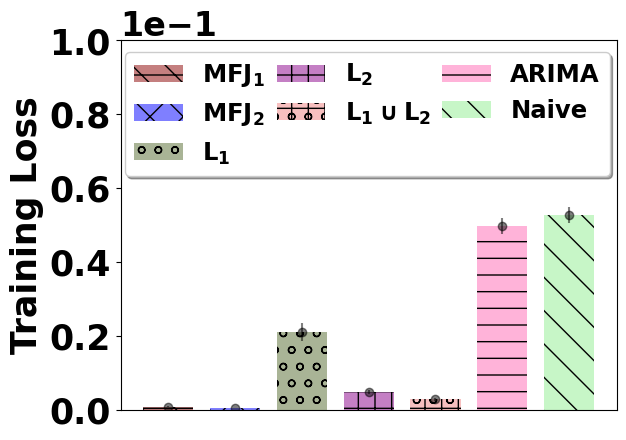

multi1 -> 0.0010665868630535882
multi2 -> 0.0006548909035508139
l1 -> 0.013286417014277501
l2 -> 0.00448361231084749
lboth -> 0.0034180397791082574
arima -> 0.002040783050598586
naive -> 0.004436869475194711


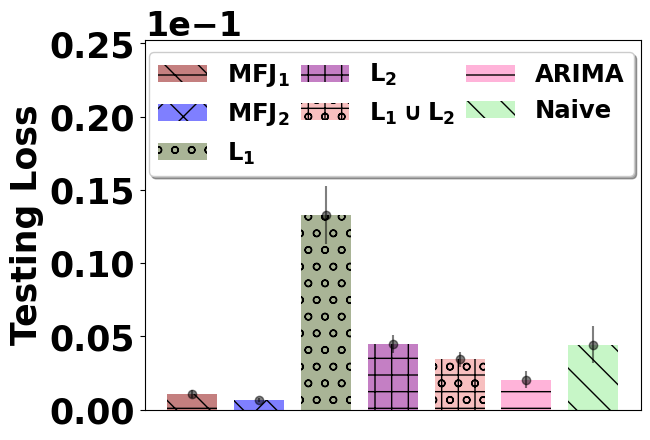

In [19]:
plot_loss(alg_results, 'train', window_size, generated_formulation1, dataset_name)
plot_loss(alg_results, 'test', window_size, generated_formulation1, dataset_name)

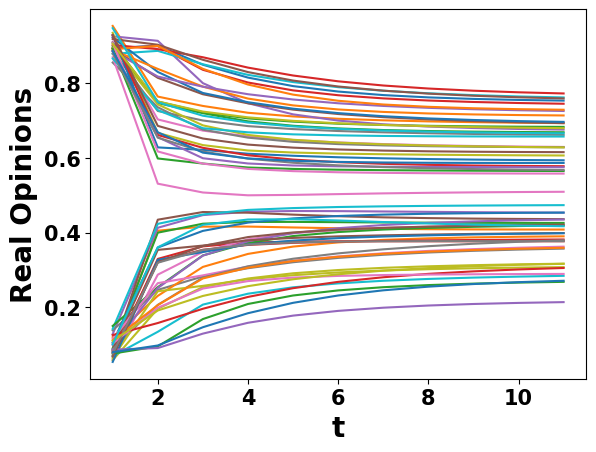

In [22]:
list_for_each_node = [[] for _ in range(_name_n[1])]
for i in range(_name_n[1]):
    for j in range(11):
        list_for_each_node[i].append(0)
for tt in range(10):
    for t in range(len(dataset[tt]['x'])):
        ar = np.array(dataset[tt]['x'][t].T)[0]
        for i in range(len(np.array(dataset[tt]['x'][t].T)[0])):
            list_for_each_node[i][t] += ar[i]/10

for i in range(_name_n[1]):
    plt.plot(range(1,12), list_for_each_node[i])

y_label = 'Real Opinions'  
x_label = 't'     
plt.ylabel(y_label, fontsize=20)
plt.xlabel(x_label, fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(f'./Figures/convergence_{int(window_size)}_{int(generated_formulation1)}_{dataset_name}.pdf', bbox_inches='tight', 
                format='pdf',dpi=1200)
plt.show()

In [23]:
import pickle 

with open(f'./Figures/real_dataset_{int(window_size)}_{int(generated_formulation1)}_{dataset_name}', 'wb') as f:
    pickle.dump(dataset, f)

with open(f'./Figures/real_alg_results_{int(window_size)}_{int(generated_formulation1)}_{dataset_name}', 'wb') as f:
    pickle.dump(alg_results, f)